In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# فصل ۲ — مبانی داده و پیش‌پردازش
## درس ۱: درک انواع داده و ساختارهای داده

**دوره:** دوره مقدماتی یادگیری ماشین (داده‌های جدولی / مسیر کلاسیک)  
**هدف این درس:** ساختن یک مدل ذهنی عملی از این‌که *چه نوع داده‌هایی ممکن است داشته باشیم* و *این داده‌ها در پایتون و زنجیره ابزارهای یادگیری ماشین چگونه نمایش داده می‌شوند*.

این درس عمداً عملی طراحی شده است: چند مجموعه‌داده به سبک CSV را بررسی می‌کنید، نوع داده‌ها را اعتبارسنجی و تبدیل می‌کنید، و انتخاب نوع داده را به مدل‌سازی، ارزیابی و هزینه محاسباتی متصل می‌کنید.


In [2]:
# Core imports used throughout the lesson
import numpy as np
import pandas as pd

from pathlib import Path
import random

import matplotlib.pyplot as plt

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print("Environment ready. RANDOM_SEED =", RANDOM_SEED)


Environment ready. RANDOM_SEED = 42


In [3]:
# A minimal translation helper for Persian notebook outputs (labels/titles).
# Code stays the same structure; only user-facing strings differ.
LANG = "fa"

def T(en: str, fa: str) -> str:
    return fa if LANG == "fa" else en

print(T("Environment ready.", "محیط آماده است."), "RANDOM_SEED =", 42)


محیط آماده است. RANDOM_SEED = 42


In [4]:
# Dataset paths (relative to this notebook location: Tutorials/<Language>/Chapter2)
from pathlib import Path

DATASETS = {
    "iris": Path("../../../Datasets/Classification/iris.csv"),
    "house_prices": Path("../../../Datasets/Regression/house-prices.csv"),
    "listings": Path("../../../Datasets/Regression/listings.csv"),
    "airports": Path("../../../Datasets/Clustering/airports.csv"),
    "hw_200": Path("../../../Datasets/Clustering/hw_200.csv"),
    "earthquake": Path("../../../Datasets/Regression/earthquake.csv"),
}

def load_csv(key: str, **read_csv_kwargs) -> pd.DataFrame:
    return pd.read_csv(DATASETS[key], **read_csv_kwargs)

# Quick sanity: show a couple of resolved paths
for k in ["iris", "house_prices", "airports"]:
    p = DATASETS[k]
    print(k, "->", p, "| exists:", p.exists())


iris -> ../../../Datasets/Classification/iris.csv | exists: True
house_prices -> ../../../Datasets/Regression/house-prices.csv | exists: True
airports -> ../../../Datasets/Clustering/airports.csv | exists: True


### اهداف یادگیری

در پایان این درس باید بتوانید:

1. **مقیاس‌های اندازه‌گیری** (اسمی / ترتیبی / فاصله‌ای / نسبتی) را از هم تفکیک کنید و آن‌ها را به ویژگی‌های یادگیری ماشین نگاشت کنید.
2. یک مجموعه‌داده را از نظر ستون‌های **عددی**، **رده‌ای**، **بولی**، **متنی**، **تاریخ‌زمان** و **مکانی (ژئواسپیشال)** ممیزی کنید.
3. ساختارهای رایج داده در یادگیری ماشین را توضیح دهید: اسکالر، بردار، ماتریس، تنسور، جدول، ماتریس تنک.
4. با Python و NumPy و pandas نوع داده‌ها را **بازرسی**، **تبدیل** و **اعتبارسنجی** کنید.
5. بین صحت، حافظه و سرعت، مصالحه‌های آگاهانه انجام دهید (مثلاً `category` در برابر `object`، یا `float32` در برابر `float64`).


## ۱) نوع داده در یادگیری ماشین: فقط «int یا float» نیست

«نوع داده» فقط قالب ذخیره‌سازی نیست. در یک پایپ‌لاین یادگیری ماشین، نوع داده تعیین می‌کند:

- **چه عملیات‌هایی معنی‌دار هستند** (آیا ترتیب دارد؟ آیا میانگین گرفتن معنی دارد؟ آیا فاصله تعریف‌پذیر است؟).
- **کدام مدل‌ها می‌توانند آن را مصرف کنند** (مدل‌های خطی ورودی عددی می‌خواهند؛ درخت‌ها با کدگذاری ترتیبی خوب کنار می‌آیند؛ روش‌های متنی معمولاً نیازمند بردارسازی هستند).
- **خطاها چگونه ظاهر می‌شوند** (تبدیل نوع داده به‌صورت بی‌صدا، تولید NaN هنگام پارس کردن، انفجار تعداد ویژگی‌ها پس از one-hot).
- **هزینه محاسبه و حافظه** (مثلاً `float32` تقریباً نصف `float64` حافظه می‌گیرد؛ `category` رشته‌های تکراری را فشرده می‌کند).

یک دسته‌بندی مفید، **مقیاس اندازه‌گیری** است:

- **اسمی (Nominal):** نام/برچسب، بدون ترتیب (شهر، رنگ، نوع محصول).
- **ترتیبی (Ordinal):** رده‌های دارای ترتیب (کوچک/متوسط/بزرگ، سطح تحصیلات).
- **فاصله‌ای (Interval):** اختلاف‌ها معنی‌دار، صفر قراردادی (دمای °C).
- **نسبتی (Ratio):** اختلاف‌ها + صفر واقعی (طول، وزن، قیمت).

در داده‌های جدولی، اکثر مدل‌ها در نهایت یک ماتریس عددی مصرف می‌کنند:

$$X \in \mathbb{R}^{n \times d}, \quad y \in \mathcal{Y}$$

اما این‌که ستون‌های مختلف را چگونه به $X$ **کدگذاری** کنید، بسیار مهم است.


## ۲) ساختارهای داده: از اسکالر تا جدول (و چرا شکل داده مهم است)

بیشتر کتابخانه‌های یادگیری ماشین با آرایه‌هایی کار می‌کنند که **شکل (shape)** مشخص دارند:

- **اسکالر:** یک مقدار منفرد، مثلاً $x \in \mathbb{R}$.
- **بردار:** $\mathbf{x} \in \mathbb{R}^{d}$ (یک نمونه با $d$ ویژگی).
- **ماتریس:** $X \in \mathbb{R}^{n \times d}$ (مجموعه‌داده جدولی).
- **تنسور:** آرایه‌های چندبعدی‌تر، مثلاً $\mathbb{R}^{n \times t \times d}$ برای داده‌های دنباله‌ای.

داده‌های جدولی معمولاً در یک **DataFrame** نگهداری می‌شوند، اما محاسبات زیرساختی غالباً روی موارد زیر انجام می‌شود:

- آرایه‌های NumPy (`ndarray`)
- ماتریس‌های تنک SciPy (وقتی پس از one-hot، بیشتر عناصر صفر هستند)
- قالب‌های ستونی مثل Parquet/Arrow در محیط‌های تولید

یک عادت حرفه‌ای: قبل از مدل‌سازی، همیشه **shape** و **dtype** را کنترل کنید.


## ۳) انواع داده در Python در برابر dtype در NumPy و pandas

معمولاً سه لایه با هم اشتباه گرفته می‌شوند:

- **نوع‌های Python** مثل (`int`, `float`, `str`, `list`, `dict`) انعطاف‌پذیر هستند، اما برای آرایه‌های بزرگ از نظر حافظه بهینه نیستند.
- **dtype در NumPy** مثل (`int64`, `float32`, `datetime64[ns]`) اندازه ثابت دارند، برداری‌سازی شده‌اند و سریع هستند.
- **dtype در pandas** روی NumPy و نوع‌های توسعه‌یافته بنا شده است (`category`, `string`, `Int64`, `boolean`).

یک DataFrame می‌تواند ستون‌هایی با dtype متفاوت داشته باشد که برای داده‌های جدولی دقیقاً مطلوب است.

نکته عملی: ستون‌هایی با dtype `object` در pandas معمولاً نشانه‌ای از **نوع‌های مخلوط** یا **رشته‌ها** در یک ظرف عمومی هستند. تبدیل به `category` یا `string` یا نوع‌های عددی، غالباً هم صحت را بهتر می‌کند و هم کارایی را.


In [5]:
# Python types: scalars and container structures
a = 7
b = 3.14
c = True
d = "ML"

lst = [1, 2, 3]
tpl = (1, 2, 3)
st = {1, 2, 3}
mp = {"feature": "sepal_length", "value": 5.4}

objects = [a, b, c, d, lst, tpl, st, mp]
for obj in objects:
    print(f"{repr(obj):>35}  ->  type: {type(obj)}")


                                  7  ->  type: <class 'int'>
                               3.14  ->  type: <class 'float'>
                               True  ->  type: <class 'bool'>
                               'ML'  ->  type: <class 'str'>
                          [1, 2, 3]  ->  type: <class 'list'>
                          (1, 2, 3)  ->  type: <class 'tuple'>
                          {1, 2, 3}  ->  type: <class 'set'>
{'feature': 'sepal_length', 'value': 5.4}  ->  type: <class 'dict'>


In [6]:
# NumPy dtype and shape fundamentals
x = np.array([1, 2, 3])
y = np.array([1, 2, 3], dtype=np.float32)

X = np.array([[1, 2, 3],
              [4, 5, 6]], dtype=np.int32)

print("x:", x, "dtype:", x.dtype, "shape:", x.shape)
print("y:", y, "dtype:", y.dtype, "shape:", y.shape)
print("X:\n", X)
print("X dtype:", X.dtype, "shape:", X.shape)
print("X nbytes:", X.nbytes)


x: [1 2 3] dtype: int64 shape: (3,)
y: [1. 2. 3.] dtype: float32 shape: (3,)
X:
 [[1 2 3]
 [4 5 6]]
X dtype: int32 shape: (2, 3)
X nbytes: 24


## ۴) ممیزی dtype روی چند مجموعه‌داده واقعی (ستون‌های ترکیبی)

چند مجموعه‌داده با «امضای نوع داده» متفاوت را بارگذاری می‌کنیم:

- **Iris** (عمدتاً عددی + برچسب رده‌ای)
- **House Prices** (عددی + دودویی + رده‌های اسمی)
- **Listings** (عددی + متن + داده‌های گم‌شده + تاریخ)
- **Airports** (شناسه‌ها، کدها، رشته‌های ترکیبی، و ستون‌های مکانی عددی)
- **HW_200** (هدر عمداً نامرتب تا اهمیت پارس و نوع داده روشن شود)

گام‌ها:

1. نمایش `head()`
2. استفاده از `info()` برای مشاهده dtypeهای تشخیص‌داده‌شده
3. اندازه‌گیری مصرف حافظه
4. تبدیل چند ستون به نوع‌های مناسب‌تر


In [7]:
# Load datasets
iris = load_csv("iris")
house = load_csv("house_prices")
listings = load_csv("listings")
airports = load_csv("airports")
hw = load_csv("hw_200")

datasets = {
    "iris": iris,
    "house_prices": house,
    "listings": listings,
    "airports": airports,
    "hw_200": hw,
}

for name, df in datasets.items():
    print("\n" + "="*80)
    print("Dataset:", name, "| shape:", df.shape)
    display(df.head())



Dataset: iris | shape: (5, 5)


,sepal_length,sepal_width,petal_length,petal_width,classification
0,5.4,3.7,1.5,0.2,Iris-setosa
1,4.8,3.4,1.6,0.2,Iris-setosa
2,4.8,3.0,1.4,0.1,Iris-setosa
3,4.3,3.0,1.1,0.1,Iris-setosa
4,5.8,4.0,1.2,0.2,Iris-setosa



Dataset: house_prices | shape: (5, 8)


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East



Dataset: listings | shape: (5, 18)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56861,-0.11270,Private room,57.0,1,51,2025-02-09,0.29,3,344,10,NaN
1,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48780,-0.16813,Entire home/apt,NaN,4,96,2024-04-28,0.52,1,11,2,NaN
2,17402,Very Central Modern 3-Bed/2 Bath By Oxford St W1,67564,Liz,NaN,Westminster,51.52195,-0.14094,Entire home/apt,510.0,3,56,2024-02-19,0.33,5,293,0,NaN
3,24328,Battersea live/work artist house,41759,Joe,NaN,Wandsworth,51.47072,-0.16266,Entire home/apt,213.0,90,94,2022-07-19,0.54,1,194,0,NaN
4,31036,Bright compact 1 Bedroom Apartment Brick Lane,133271,Hendryks,NaN,Tower Hamlets,51.52425,-0.06997,Entire home/apt,100.0,2,126,2025-02-20,0.70,8,353,3,NaN



Dataset: airports | shape: (6, 19)


,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11,NaN,US,US-PA,Bensalem,no,NaN,NaN,K00A,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435,NaN,US,US-KS,Leoti,no,NaN,NaN,00AA,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450,NaN,US,US-AK,Anchor Point,no,NaN,NaN,00AK,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820,NaN,US,US-AL,Harvest,no,NaN,NaN,00AL,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80,NaN,US,US-AK,King Salmon,no,NaN,NaN,00AN,00AN,NaN,NaN,NaN



Dataset: hw_200 | shape: (6, 3)


,Index,"Height(Inches)""","""Weight(Pounds)"""
0,1,65.78,112.99
1,2,71.52,136.49
2,3,69.40,153.03
3,4,68.22,142.34
4,5,67.79,144.30


In [8]:
import io

def dtype_audit(df: pd.DataFrame, name: str):
    print("\n" + "-"*80)
    print("Audit:", name)
    display(df.dtypes.to_frame("dtype").T)

    sio = io.StringIO()
    df.info(buf=sio)
    print(sio.getvalue())

    mem = df.memory_usage(deep=True).sum()
    print("Approx. memory (bytes):", int(mem))
    print("Approx. memory (KB):", round(mem/1024, 2))

for name, df in datasets.items():
    dtype_audit(df, name)



--------------------------------------------------------------------------------
Audit: iris


,sepal_length,sepal_width,petal_length,petal_width,classification
dtype,float64,float64,float64,float64,object


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sepal_length    5 non-null      float64
 1   sepal_width     5 non-null      float64
 2   petal_length    5 non-null      float64
 3   petal_width     5 non-null      float64
 4   classification  5 non-null      object 
dtypes: float64(4), object(1)
memory usage: 332.0+ bytes

Approx. memory (bytes): 632
Approx. memory (KB): 0.62

--------------------------------------------------------------------------------
Audit: house_prices


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
dtype,int64,int64,int64,int64,int64,int64,object,object


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Home          5 non-null      int64 
 1   Price         5 non-null      int64 
 2   SqFt          5 non-null      int64 
 3   Bedrooms      5 non-null      int64 
 4   Bathrooms     5 non-null      int64 
 5   Offers        5 non-null      int64 
 6   Brick         5 non-null      object
 7   Neighborhood  5 non-null      object
dtypes: int64(6), object(2)
memory usage: 452.0+ bytes

Approx. memory (bytes): 972
Approx. memory (KB): 0.95

--------------------------------------------------------------------------------
Audit: listings


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
dtype,int64,object,int64,object,float64,object,float64,float64,object,float64,int64,int64,object,float64,int64,int64,int64,float64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              5 non-null      int64  
 1   name                            5 non-null      object 
 2   host_id                         5 non-null      int64  
 3   host_name                       5 non-null      object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   5 non-null      object 
 6   latitude                        5 non-null      float64
 7   longitude                       5 non-null      float64
 8   room_type                       5 non-null      object 
 9   price                           4 non-null      float64
 10  minimum_nights                  5 non-null      int64  
 11  number_of_reviews               5 non-null      int64  
 12  last_review                     5 non-nu

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
dtype,int64,object,object,object,float64,float64,int64,float64,object,object,object,object,float64,float64,object,object,object,float64,float64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 6 non-null      int64  
 1   ident              6 non-null      object 
 2   type               6 non-null      object 
 3   name               6 non-null      object 
 4   latitude_deg       6 non-null      float64
 5   longitude_deg      6 non-null      float64
 6   elevation_ft       6 non-null      int64  
 7   continent          0 non-null      float64
 8   iso_country        6 non-null      object 
 9   iso_region         6 non-null      object 
 10  municipality       6 non-null      object 
 11  scheduled_service  6 non-null      object 
 12  icao_code          0 non-null      float64
 13  iata_code          0 non-null      float64
 14  gps_code           6 non-null      object 
 15  local_code         6 non-null      object 
 16  home_link          1 non-null 

,Index,"Height(Inches)""","""Weight(Pounds)"""
dtype,int64,float64,float64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Index              6 non-null      int64  
 1    Height(Inches)"   6 non-null      float64
 2    "Weight(Pounds)"  6 non-null      float64
dtypes: float64(2), int64(1)
memory usage: 276.0 bytes

Approx. memory (bytes): 276
Approx. memory (KB): 0.27


## ۴.۱) چند نمودار سریع برای اتصال نوع داده به EDA

حتی در درس «نوع داده»، رسم نمودار مفید است:

- ستون‌های عددی → هیستوگرام، باکس‌پلات
- ستون‌های رده‌ای → نمودار میله‌ای
- عددی در برابر عددی → پراکنش (scatter)

برای داده iris یک هیستوگرام و یک نمودار پراکنش رسم می‌کنیم.


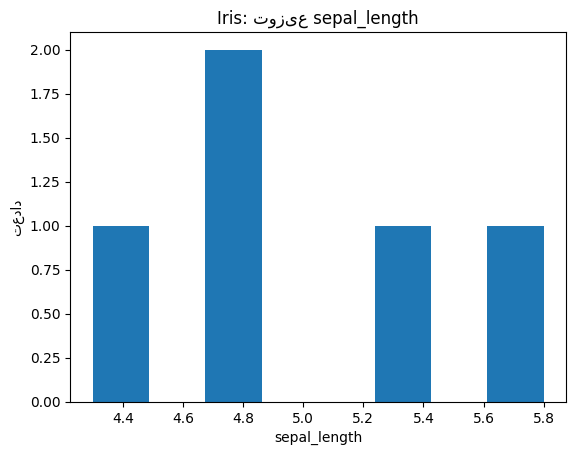

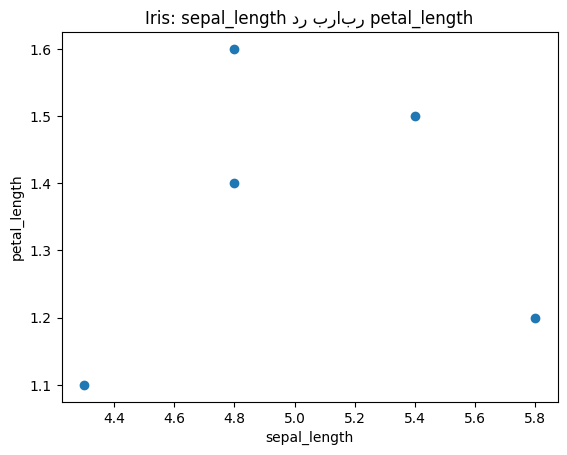

In [9]:
iris_num = iris.copy()

plt.figure()
iris_num["sepal_length"] = pd.to_numeric(iris_num["sepal_length"], errors="coerce")
plt.hist(iris_num["sepal_length"].dropna(), bins=8)
plt.title(T("Iris: sepal_length distribution", "Iris: توزیع sepal_length"))
plt.xlabel(T("sepal_length", "sepal_length"))
plt.ylabel(T("count", "تعداد"))
plt.show()

plt.figure()
plt.scatter(iris_num["sepal_length"], pd.to_numeric(iris_num["petal_length"], errors="coerce"))
plt.title(T("Iris: sepal_length vs petal_length", "Iris: sepal_length در برابر petal_length"))
plt.xlabel(T("sepal_length", "sepal_length"))
plt.ylabel(T("petal_length", "petal_length"))
plt.show()


## ۵) تبدیل نوع ستون‌ها: صحت + کارایی

### ۵.۱ ستون‌های رده‌ای (Categorical)

اگر ستونی تعداد کمی مقدار رشته‌ای تکراری داشته باشد (مثل `Neighborhood` یا `room_type`)، dtype `category` معمولاً بهتر از `object` است:

- کاهش مصرف حافظه (کدگذاری واژگانی/دیکشنری)
- صریح شدن مقادیر مجاز (مفید برای اعتبارسنجی)
- جلوگیری از خطاهای تایپی خاموش (مثلاً “Eats” به جای “East”)

### ۵.۲ اعداد صحیح همراه با مقدار گم‌شده

در pandas، ستون `int64` معمولی نمی‌تواند مقدار گم‌شده را نگه دارد. اگر به missing نیاز دارید از dtype صحیحِ nullable استفاده کنید: `Int64` (با I بزرگ).

### ۵.۳ تاریخ‌زمان

تاریخ‌ها رشته نیستند. وقتی ستونی ماهیت زمانی دارد، آن را به `datetime64[ns]` تبدیل کنید تا مقایسه، مرتب‌سازی، نمونه‌برداری زمانی و اختلاف زمانی درست کار کند.

اکنون این تبدیل‌ها را روی دو مجموعه‌داده اعمال می‌کنیم.


In [10]:
# --- House prices: convert a few obvious categories ---
house2 = house.copy()

house2["Brick"] = house2["Brick"].astype("category")
house2["Neighborhood"] = house2["Neighborhood"].astype("category")

# Ensure numeric columns are numeric
for col in ["Price", "SqFt", "Bedrooms", "Bathrooms", "Offers"]:
    house2[col] = pd.to_numeric(house2[col], errors="coerce")

print("Before:")
display(house.dtypes.to_frame("dtype").T)
print("After:")
display(house2.dtypes.to_frame("dtype").T)

print("Memory before (bytes):", int(house.memory_usage(deep=True).sum()))
print("Memory after  (bytes):", int(house2.memory_usage(deep=True).sum()))


Before:


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
dtype,int64,int64,int64,int64,int64,int64,object,object


After:


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
dtype,int64,int64,int64,int64,int64,int64,category,category


Memory before (bytes): 972
Memory after  (bytes): 718


In [11]:
# --- Listings: parse dates, numeric, categories ---
lst2 = listings.copy()

# Parse last_review to datetime
lst2["last_review"] = pd.to_datetime(lst2["last_review"], errors="coerce")

# price is numeric but has missing values -> float
lst2["price"] = pd.to_numeric(lst2["price"], errors="coerce")

# categorical columns
for col in ["neighbourhood", "room_type", "host_name"]:
    lst2[col] = lst2[col].astype("category")

print("Dtypes after conversions:")
display(lst2.dtypes.to_frame("dtype").T)

# Quick checks
print("last_review min/max:", lst2["last_review"].min(), "/", lst2["last_review"].max())
print("price has NaN count:", int(lst2["price"].isna().sum()))


Dtypes after conversions:


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
dtype,int64,object,int64,category,float64,category,float64,float64,category,float64,int64,int64,datetime64[ns],float64,int64,int64,int64,float64


last_review min/max: 2022-07-19 00:00:00 / 2025-02-20 00:00:00
price has NaN count: 1


## ۶) وقتی dtype و ساختار خراب می‌شود: مثال «هدر نامرتب»

CSVهای دنیای واقعی معمولاً نامرتب هستند: کوتیشن‌های اضافی، فاصله‌های انتهایی، نمادهای عجیب یا نام‌گذاری ناسازگار.

یک نشانه رایج، خطایی مثل `KeyError: 'Height(Inches)'` است؛ چون نام واقعی ستون شامل کاراکترهای پنهان یا فاصله/کوتیشن اضافی است.

در `hw_200` ابتدا نام ستون‌ها را بررسی می‌کنیم و سپس آن‌ها را نرمال‌سازی می‌کنیم:

- حذف فاصله‌های اضافی
- حذف کوتیشن‌ها
- تبدیل فاصله‌های تکراری به یک فاصله
- استانداردسازی نام‌ها به یک سبک امن

این یک مسئله **ساختار داده** است: اسکیمای جدول (نام ستون‌ها + dtypeها) بخشی از داده است.


In [12]:
import re

hw2 = hw.copy()

print("Raw columns:")
for col in hw2.columns:
    print(repr(col))

def clean_col(name: str) -> str:
    name = name.strip()
    name = name.replace('"', "")
    name = re.sub(r"\s+", " ", name)
    # remove spaces around punctuation
    name = name.replace(" (", "(").replace(") ", ")")
    return name

hw2.columns = [clean_col(c) for c in hw2.columns]

print("\nCleaned columns:")
for col in hw2.columns:
    print(repr(col))

display(hw2.head())

# Coerce numeric columns
for col in hw2.columns:
    hw2[col] = pd.to_numeric(hw2[col], errors="coerce")

display(hw2.dtypes.to_frame("dtype").T)


Raw columns:
'Index'
' Height(Inches)"'
' "Weight(Pounds)"'

Cleaned columns:
'Index'
'Height(Inches)'
'Weight(Pounds)'


,Index,Height(Inches),Weight(Pounds)
0,1,65.78,112.99
1,2,71.52,136.49
2,3,69.40,153.03
3,4,68.22,142.34
4,5,67.79,144.30


,Index,Height(Inches),Weight(Pounds)
dtype,int64,float64,float64


## ۷) نگاه دقیق‌تر به ویژگی‌های «متنی» (object در برابر string در برابر category)

در pandas:

- `object` به‌صورت تاریخی ظرف عمومی برای اشیای Python بوده است (اغلب رشته‌ها).
- `string` (StringDtype در pandas) نوع اختصاصی رشته است و مدیریت missing بهتری دارد.
- `category` نمایش واژگانی/دیکشنری‌محور است و وقتی تعداد مقادیر یکتا محدود است مناسب است.

قاعده سرانگشتی:

- متن آزاد (نقد/روایت/شرح) → `string` (بعداً به عدد بردارسازی می‌شود).
- برچسب‌های با واژگان کوچک (نام شهر، نوع محصول) → `category`.
- فیلدهای مخلوط یا نامرتب → ابتدا ممیزی کنید (`object` اغلب علامت خطر است).

اکنون مصرف حافظه این انتخاب‌ها را روی یک مثال کوچک از داده listings مقایسه می‌کنیم.


In [13]:
toy = pd.DataFrame({
    "neighbourhood": listings["neighbourhood"].astype("object"),
    "host_name": listings["host_name"].astype("object"),
})

toy_obj = toy.copy()
toy_str = toy.copy()
toy_cat = toy.copy()

toy_str["neighbourhood"] = toy_str["neighbourhood"].astype("string")
toy_str["host_name"] = toy_str["host_name"].astype("string")

toy_cat["neighbourhood"] = toy_cat["neighbourhood"].astype("category")
toy_cat["host_name"] = toy_cat["host_name"].astype("category")

def mem(df): 
    return int(df.memory_usage(deep=True).sum())

out = pd.DataFrame({
    "object": [mem(toy_obj)],
    "string": [mem(toy_str)],
    "category": [mem(toy_cat)],
}, index=["memory_bytes"]).T

display(out)


,memory_bytes
object,794
string,794
category,1148


## ۸) دقت عددی و پایداری: `float32` در برابر `float64`

بسیاری از مدل‌ها و مراحل پیش‌پردازش از نظر عددی حساس هستند و انتخاب دقت اهمیت دارد:

- `float64` معمولاً امن‌ترین پیش‌فرض در اکوسیستم علمی Python است.
- `float32` حافظه را نصف می‌کند و گاهی سریع‌تر است، اما می‌تواند خطای گرد کردن را انباشته کند.

رویکرد عملی:

1. در اکتشاف و اعتبارسنجی اولیه، داده خام را `float64` نگه دارید.
2. وقتی پایپ‌لاین پایدار شد و مانیتورینگ دارید، برای داده‌های بسیار بزرگ به `float32` فکر کنید.

اثر دقت را روی یک محاسبه ساده نشان می‌دهیم: جمع کردن تعداد زیادی عدد کوچک.


In [14]:
n = 2_000_000
small = np.full(n, 1e-6, dtype=np.float64)
small32 = small.astype(np.float32)

s64 = small.sum()
s32 = small32.sum()

print("Expected:", n * 1e-6)
print("float64 sum:", s64, "abs error:", abs(s64 - n*1e-6))
print("float32 sum:", float(s32), "abs error:", abs(float(s32) - n*1e-6))


Expected: 2.0
float64 sum: 1.9999999999999953 abs error: 4.6629367034256575e-15
float32 sum: 1.9999934434890747 abs error: 6.556510925292969e-06


## ۹) ساختارهای تاریخ‌زمان: ترکیب date و time و محاسبه اختلاف زمانی

مدل‌سازی سری زمانی و حتی EDA پایه نیازمند dtype درست برای تاریخ‌زمان است.

در `earthquake.csv` ستون‌های `date` و `time` جدا هستند. ما:

1. آن‌ها را پارس می‌کنیم
2. به یک timestamp واحد تبدیل می‌کنیم
3. پس از مرتب‌سازی، اختلاف زمانی رخدادهای متوالی را محاسبه می‌کنیم

این مثال نشان می‌دهد چرا تاریخ‌زمان یک نوع مستقل است، نه صرفاً متن.


In [15]:
eq = load_csv("earthquake")

eq["timestamp"] = pd.to_datetime(eq["date"] + " " + eq["time"], errors="coerce")
eq = eq.sort_values("timestamp").reset_index(drop=True)

eq["delta_minutes"] = eq["timestamp"].diff().dt.total_seconds() / 60.0

display(eq[["date", "time", "timestamp", "delta_minutes", "magnitude"]])

print("timestamp dtype:", eq["timestamp"].dtype)
print("Mean delta (minutes):", round(eq["delta_minutes"].mean(skipna=True), 3))


,date,time,timestamp,delta_minutes,magnitude
0,2008-11-01,00:31:25,2008-11-01 00:31:25,NaN,2.99
1,2008-11-01,01:34:29,2008-11-01 01:34:29,63.066667,5.51
2,2008-11-01,01:38:14,2008-11-01 01:38:14,3.750000,3.54
3,2008-11-01,02:20:05,2008-11-01 02:20:05,41.850000,2.42
4,2008-11-01,02:32:18,2008-11-01 02:32:18,12.216667,2.41


timestamp dtype: datetime64[ns]
Mean delta (minutes): 30.221


## ۱۰) ستون‌های مکانی: عرض/طول جغرافیایی عددی هستند، اما *هندسه را کد می‌کنند*

عرض و طول جغرافیایی از نوع float هستند، اما «عدد عمومی» نیستند. مثلاً فاصله اقلیدسی روی درجه‌ها می‌تواند گمراه‌کننده باشد.

یک روش سبک برای فاصله روی کره، فرمول هاورساین است:

$$d = 2R \arcsin\left(\sqrt{\sin^2\left(\frac{\Delta\varphi}{2}\right) + \cos(\varphi_1)\cos(\varphi_2)\sin^2\left(\frac{\Delta\lambda}{2}\right)}\right)$$

برای نشان دادن این‌که ستون‌های عددی می‌توانند معنای دامنه‌ای داشته باشند، فاصله تقریبی چند فرودگاه را محاسبه می‌کنیم.


In [16]:
air = airports.copy()

# Ensure numeric
air["latitude_deg"] = pd.to_numeric(air["latitude_deg"], errors="coerce")
air["longitude_deg"] = pd.to_numeric(air["longitude_deg"], errors="coerce")

# Pick a few airports with valid coords
sample_air = air.dropna(subset=["latitude_deg", "longitude_deg"]).head(4).reset_index(drop=True)
display(sample_air[["ident", "name", "latitude_deg", "longitude_deg", "iso_region"]])

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlmb = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*(np.sin(dlmb/2)**2)
    return 2*R*np.arcsin(np.sqrt(a))

pairs = []
for i in range(len(sample_air)):
    for j in range(i+1, len(sample_air)):
        d = haversine_km(sample_air.loc[i,"latitude_deg"], sample_air.loc[i,"longitude_deg"],
                         sample_air.loc[j,"latitude_deg"], sample_air.loc[j,"longitude_deg"])
        pairs.append((sample_air.loc[i,"ident"], sample_air.loc[j,"ident"], d))

dist_df = pd.DataFrame(pairs, columns=["from", "to", "distance_km"])
display(dist_df)


,ident,name,latitude_deg,longitude_deg,iso_region
0,00A,Total RF Heliport,40.070985,-74.933689,US-PA
1,00AA,Aero B Ranch Airport,38.704022,-101.473911,US-KS
2,00AK,Lowell Field,59.947733,-151.692524,US-AK
3,00AL,Epps Airpark,34.864799,-86.770302,US-AL


,from,to,distance_km
0,00A,00AA,2277.457507
1,00A,00AK,5541.519489
2,00A,00AL,1192.845305
3,00AA,00AK,4191.236344
4,00AA,00AL,1375.413553
5,00AK,00AL,5338.865869


## ۱۱) تنک در برابر چگال: وقتی one-hot فضای ویژگی را منفجر می‌کند

ویژگی‌های رده‌ای اغلب با one-hot به ماتریس عددی تبدیل می‌شوند.

اگر ستونی $k$ مقدار یکتا داشته باشد، one-hot تعداد $k$ ویژگی دودویی می‌سازد. در چند ستون با کاردینالیتی بالا، $d$ بسیار بزرگ می‌شود و ماتریس غالباً پر از صفر است.

ماتریس تنک فقط مقادیر غیرصفر را ذخیره می‌کند و می‌تواند از نظر حافظه بسیار بهینه‌تر باشد.

یک مثال کوچک one-hot می‌سازیم و نمایش چگال و تنک را مقایسه می‌کنیم.


In [17]:
from scipy import sparse

cats = pd.Series(["East","East","North","West","East","West","South","South","East","North"], name="Neighborhood")
onehot = pd.get_dummies(cats)

dense = onehot.to_numpy(dtype=np.int8)
sp = sparse.csr_matrix(dense)

print("One-hot shape:", dense.shape)
print("Dense nbytes:", dense.nbytes)
print("Sparse nnz (non-zeros):", sp.nnz)
print("Sparse data nbytes:", sp.data.nbytes)

display(onehot.head())


One-hot shape: (10, 4)
Dense nbytes: 40
Sparse nnz (non-zeros): 10
Sparse data nbytes: 10


,East,North,South,West
0,True,False,False,False
1,True,False,False,False
2,False,True,False,False
3,False,False,False,True
4,True,False,False,False


## ۱۲) چک‌لیست عملی: سلامت dtype و ساختار قبل از مدل‌سازی

قبل از آموزش مدل، یک چک‌لیست حداقلی را اعمال کنید:

1. **شفافیت اسکیمای داده**
   - نام ستون‌ها تمیز و سازگار باشد.
   - برای هر ستون «معنا» و dtype مورد انتظار تعریف شده باشد.

2. **صحت نوع**
   - ستون‌های عددی واقعاً عددی باشند (`int` یا `float`)، نه رشته.
   - ستون‌های رده‌ای رده‌ای باشند (یا به‌صورت صریح کدگذاری شوند).
   - ستون‌های زمانی پارس شده باشند و سیاست منطقه زمانی مشخص باشد.

3. **سیاست missing**
   - بدانید کدام ستون‌ها ممکن است گم شوند و چرا.
   - نمایش missing یکدست باشد (NaN / NA).

4. **انضباط شکل**
   - ماتریس ویژگی $X$ ابعاد $n \times d$ و برچسب‌ها $y$ طول $n$ داشته باشند.
   - نشت اندیس/شناسه رخ ندهد (مثلاً استفاده از ID ردیف به‌عنوان ویژگی).

5. **حافظه و کارایی**
   - رده‌های واضح را `category` کنید؛ dtype `object` ناخواسته در ستون‌های بزرگ خطرناک است.
   - در one-hotهای بزرگ، به ماتریس تنک فکر کنید.

در ادامه یک ابزار کوچک گزارش dtype می‌سازیم که قابل استفاده مجدد باشد.


In [18]:
def dtype_report(df: pd.DataFrame) -> pd.DataFrame:
    example = df.head(3).apply(lambda s: ", ".join([str(v) for v in s.tolist()]), axis=0)
    rep = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "n_missing": df.isna().sum(),
        "missing_rate": (df.isna().mean()).round(3),
        "n_unique": df.nunique(dropna=True),
        "example_values": example,
    })
    rep = rep.sort_values(["dtype", "n_unique"])
    return rep

report_listings = dtype_report(lst2)
display(report_listings.head(20))


,dtype,n_missing,missing_rate,n_unique,example_values
room_type,category,0,0.0,2,"Private room, Entire home/apt, Entire home/apt"
host_name,category,0,0.0,5,"Alina, Philippa, Liz"
neighbourhood,category,0,0.0,5,"Islington, Kensington and Chelsea, Westminster"
last_review,datetime64[ns],0,0.0,5,"2025-02-09 00:00:00, 2024-04-28 00:00:00, 2024..."
neighbourhood_group,float64,5,1.0,0,"nan, nan, nan"
license,float64,5,1.0,0,"nan, nan, nan"
price,float64,1,0.2,4,"57.0, nan, 510.0"
latitude,float64,0,0.0,5,"51.56861, 51.4878, 51.52195"
longitude,float64,0,0.0,5,"-0.1127, -0.16813, -0.14094"
reviews_per_month,float64,0,0.0,5,"0.29, 0.52, 0.33"


## ۱۳) تمرین‌های کوتاه (همراه با حل)

### تمرین A — شناسایی و تبدیل نوع‌ها
روی `listings`:

1. ستون `room_type` را به `category` تبدیل کنید.
2. ستون `price` را عددی کنید.
3. ستون `last_review` را به datetime تبدیل کنید.
4. مصرف حافظه قبل و بعد را گزارش دهید.

### تمرین B — انضباط شکل
برای داده iris، $X$ و $y$ بسازید به‌طوری‌که:

- $X$ شامل چهار ستون عددی باشد
- $y$ ستون `classification` باشد

بررسی کنید $X$ ابعاد $n \times 4$ دارد و `sklearn` می‌تواند آن را مصرف کند.

حل مرجع در ادامه آمده است.


In [19]:
# Exercise A solution
lst_raw = listings.copy()
mem_before = int(lst_raw.memory_usage(deep=True).sum())

lst_sol = lst_raw.copy()
lst_sol["room_type"] = lst_sol["room_type"].astype("category")
lst_sol["price"] = pd.to_numeric(lst_sol["price"], errors="coerce")
lst_sol["last_review"] = pd.to_datetime(lst_sol["last_review"], errors="coerce")

mem_after = int(lst_sol.memory_usage(deep=True).sum())

print("Memory before (bytes):", mem_before)
print("Memory after  (bytes):", mem_after)
print("Reduction (%):", round(100*(mem_before - mem_after)/mem_before, 2))

display(lst_sol.dtypes.to_frame("dtype").T)
display(lst_sol.head())


Memory before (bytes): 2487
Memory after  (bytes): 2089
Reduction (%): 16.0


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
dtype,int64,object,int64,object,float64,object,float64,float64,category,float64,int64,int64,datetime64[ns],float64,int64,int64,int64,float64


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56861,-0.11270,Private room,57.0,1,51,2025-02-09,0.29,3,344,10,NaN
1,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48780,-0.16813,Entire home/apt,NaN,4,96,2024-04-28,0.52,1,11,2,NaN
2,17402,Very Central Modern 3-Bed/2 Bath By Oxford St W1,67564,Liz,NaN,Westminster,51.52195,-0.14094,Entire home/apt,510.0,3,56,2024-02-19,0.33,5,293,0,NaN
3,24328,Battersea live/work artist house,41759,Joe,NaN,Wandsworth,51.47072,-0.16266,Entire home/apt,213.0,90,94,2022-07-19,0.54,1,194,0,NaN
4,31036,Bright compact 1 Bedroom Apartment Brick Lane,133271,Hendryks,NaN,Tower Hamlets,51.52425,-0.06997,Entire home/apt,100.0,2,126,2025-02-20,0.70,8,353,3,NaN


In [20]:
# Exercise B solution
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

iris_df = iris.copy()

feature_cols = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
iris_df[feature_cols] = iris_df[feature_cols].apply(pd.to_numeric, errors="coerce")

# Build X and y
X = iris_df[feature_cols].to_numpy(dtype=np.float64)
y_text = iris_df["classification"].astype("string").to_numpy()

# Ensure at least two classes for a demonstration fit (small deterministic augmentation)
if pd.Series(y_text).nunique() < 2:
    X2 = X.copy()
    X2[:, 0] = X2[:, 0] + 0.7  # slight shift
    y2 = np.array(["Iris-versicolor"] * len(y_text), dtype=object)
    X = np.vstack([X, X2])
    y_text = np.concatenate([y_text, y2])

le = LabelEncoder()
y = le.fit_transform(y_text)

print("X shape:", X.shape, "dtype:", X.dtype)
print("y shape:", y.shape, "classes:", list(le.classes_))

clf = LogisticRegression(max_iter=200)
clf.fit(X, y)

print("Training accuracy (on this demo sample):", round(clf.score(X, y), 3))


X shape: (10, 4) dtype: float64
y shape: (10,) classes: ['Iris-setosa', 'Iris-versicolor']
Training accuracy (on this demo sample): 0.8


## ۱۴) جمع‌بندی

در این درس یک جریان کاری پایه را تثبیت کردید:

- تشخیص **معنای ستون‌ها** و نگاشت آن‌ها به dtype مناسب
- اعتبارسنجی **شکل** و **اسکیما** قبل از مدل‌سازی
- تبدیل به نمایش‌های کاراتر (`category`، صحیح‌های nullable، datetime)
- درک این‌که ستون‌های «عددی» هم ممکن است نیازمند تفسیر دامنه‌ای باشند (ژئواسپیشال، شناسه‌ها)

درس بعدی: **پاک‌سازی داده و مقادیر گم‌شده** — نحوه بروز missing، روش‌های کشف، و سیاست‌های امن.
